In [1]:
%pip install numpy matplotlib seaborn scikit-learn torch torchvision jupyter

Note: you may need to restart the kernel to use updated packages.


## Импорты

In [2]:
# Блок 1: Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

import warnings

warnings.filterwarnings('ignore')

## Генерация датасета

In [3]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

## Визуализация

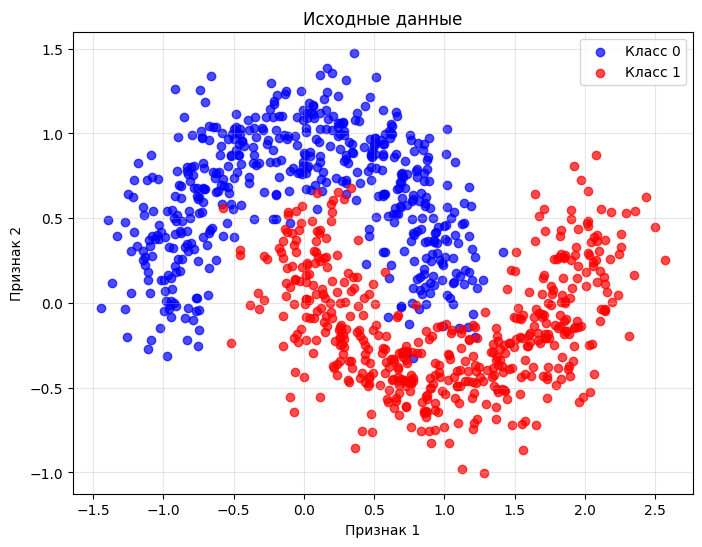

In [4]:
# Блок 3: Визуализация данных на плоскости (пункт 2)
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', alpha=0.7, label='Класс 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', alpha=0.7, label='Класс 1')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Исходные данные')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Создание MLP

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(2, 4)
        self.output = nn.Linear(4, 1)
        self.relu = nn.ReLU() 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

model = MLP()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Разделение данных

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% тестовых данных
    random_state=42,      # Для воспроизводимости
    stratify=y            # Сохраняем распределение классов
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Подготовка данных для PyTorch

In [7]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Обучение модели

In [8]:
num_epochs = 1000
train_losses = []
epoch_interval = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0
    batch_count = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    
    if (epoch + 1) % epoch_interval == 0 or epoch == 0:
        print(f"Эпоха [{epoch+1:4d}/{num_epochs}], "
              f"Потеря: {avg_loss:.6f}")

# Анализ потерь
print(f"\nНачальная потеря (эпоха 1): {train_losses[0]:.6f}")
print(f"Финальная потеря (эпоха {num_epochs}): {train_losses[-1]:.6f}")
print(f"Улучшение: {(train_losses[0] - train_losses[-1]):.6f}")

Эпоха [   1/1000], Потеря: 0.573504
Эпоха [ 100/1000], Потеря: 0.090816
Эпоха [ 200/1000], Потеря: 0.086442
Эпоха [ 300/1000], Потеря: 0.087235
Эпоха [ 400/1000], Потеря: 0.085907
Эпоха [ 500/1000], Потеря: 0.084926
Эпоха [ 600/1000], Потеря: 0.085061
Эпоха [ 700/1000], Потеря: 0.085563
Эпоха [ 800/1000], Потеря: 0.084145
Эпоха [ 900/1000], Потеря: 0.085459
Эпоха [1000/1000], Потеря: 0.085182

Начальная потеря (эпоха 1): 0.573504
Финальная потеря (эпоха 1000): 0.085182
Улучшение: 0.488323


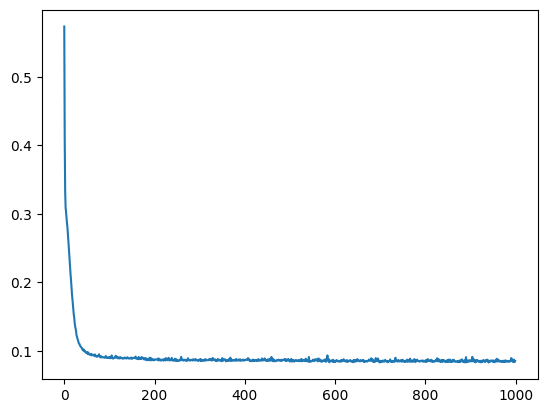

In [9]:
plt.plot(torch.tensor(train_losses))

In [10]:
model.eval()

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    
    test_preds = (test_outputs > 0.5).float()
    
    probabilities = test_outputs.numpy().flatten()

accuracy = accuracy_score(y_test, test_preds.numpy())

accuracy

0.985